#                                    Retail Sales Forecasting: A Case Study on Walmart Stores

## Step 1 – Ask
* **Business question:** How can a retail chain optimize promotions and inventory based on seasonal demand patterns and external factors?

* **Stakeholders:** Store managers (inventory planning), Marketing (promotion timing and targeting), Supply Chain (stock allocation), and Academic reviewers (evaluation of analysis methodology).

* **Objective:** Identify seasonal patterns, holiday effects, department/store differences, and produce actionable recommendations for promotion timing and inventory allocation.


## Step 2 – Prepare
* **Dataset:** “Walmart Recruiting — Store Sales Forecasting” (Kaggle). Combined files used: train.csv (weekly sales per Store & Dept), features.csv (Temperature, Fuel_Price, CPI, Unemployment, MarkDown1–5, IsHoliday), and stores.csv (Store, Type, Size).

* **Time span & granularity:** Weekly sales over multiple years across ~45 stores and many departments (exact years covered are shown in the dataset).

* **Limitations:** Markdown columns contain many missing values; there is no customer-level demographic data; external features are macro indicators, not causal proofs. These limitations are noted and handled in the Process section.


## Step 3 – Process

* Combined the three main datasets (train.csv, features.csv, stores.csv) into one master dataframe using common keys (Store, Date).

* **Handled missing values:**

    - Used forward-fill for continuous columns like CPI, Unemployment, and Fuel_Price.

    - For Markdown features (MarkDown1–5), missing values were retained for analysis transparency since imputation could distort seasonal effects.

* Converted date columns into datetime objects and extracted Year, Month, and Week features.

* Removed duplicate columns (merged IsHoliday_x and IsHoliday_y into one IsHoliday column).

* Verified data consistency — each record represents one store–department–week combination.

In [19]:
# imports & settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid', context='talk')   # nice readable style for report
data_dir = Path(r'C:\Users\ND.COM\Downloads\Walmart Recruiting - Store Sales Forecasting GSR')  # adjust if your files are elsewhere

# load CSVs
train = pd.read_csv(data_dir / 'train.csv', parse_dates=['Date'])
features = pd.read_csv(data_dir / 'features.csv', parse_dates=['Date'])
stores = pd.read_csv(data_dir / 'stores.csv')

# merge to master
master = train.merge(features, on=['Store', 'Date'], how='left').merge(stores, on='Store', how='left')

# basic cleaning
markdown_cols = [c for c in master.columns if 'MarkDown' in c]
master[markdown_cols] = master[markdown_cols].fillna(0)
master['CPI'] = master['CPI'].ffill()   # simple approach
master['Year'] = master['Date'].dt.year
master['Month'] = master['Date'].dt.month
master['Week'] = master['Date'].dt.isocalendar().week
master['IsHoliday'] = master['IsHoliday_x'].astype(bool)
master.drop(columns=['IsHoliday_x', 'IsHoliday_y'], inplace=True)


## Step 4 – Analyze

4.1 Total Weekly Sales Over Time

* **Visualization:** Line plot showing total sales aggregated across all stores per week.

* **Insight:** Overall company-wide sales follow seasonal patterns; volatility may be influenced by promotions, weather, or economic conditions.

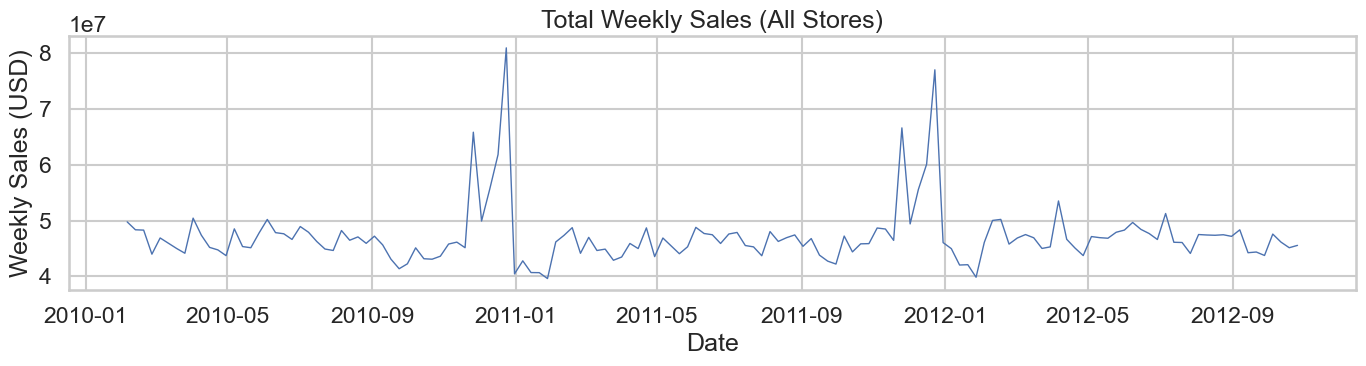

In [21]:
# Task 1: Total weekly sales time series
weekly = master.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(14,4))
plt.plot(weekly['Date'], weekly['Weekly_Sales'], linewidth=1)
plt.title('Total Weekly Sales (All Stores)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales (USD)')
plt.tight_layout()
plt.savefig('figures/weekly_total_sales.png', dpi=300)
plt.show()

4.2 Weekly Moving Average of Sales

* **Visualization:** Line plot showing the 4-week moving average of weekly sales.

* **Insight:** Sales trends show periodic increases around major holidays, with noticeable dips post-holiday — reflecting clear seasonal cycles.

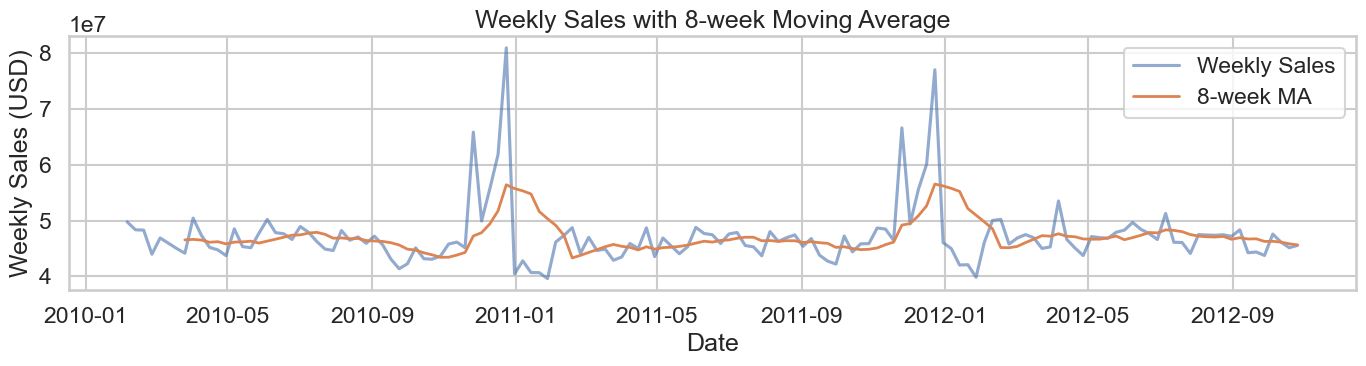

In [25]:
# Task 2: Rolling mean (moving average)
weekly = weekly.set_index('Date')
weekly['MA8'] = weekly['Weekly_Sales'].rolling(window=8).mean()

plt.figure(figsize=(14,4))
plt.plot(weekly.index, weekly['Weekly_Sales'], label='Weekly Sales', alpha=0.6)
plt.plot(weekly.index, weekly['MA8'], label='8-week MA', linewidth=2)
plt.title('Weekly Sales with 8-week Moving Average')
plt.xlabel('Date')
plt.ylabel('Weekly Sales (USD)')
plt.legend()
plt.tight_layout()
plt.savefig('figures/weekly_sales_ma.png', dpi=300)
plt.show()


4.3 Weekly Sales by Holiday vs. Non-Holiday

* **Visualization:** Boxplot comparing sales during holiday and non-holiday weeks.

* **Insight:** Average weekly sales show noticeable spikes during holiday weeks, confirming that promotions and stock allocations should anticipate increased demand.

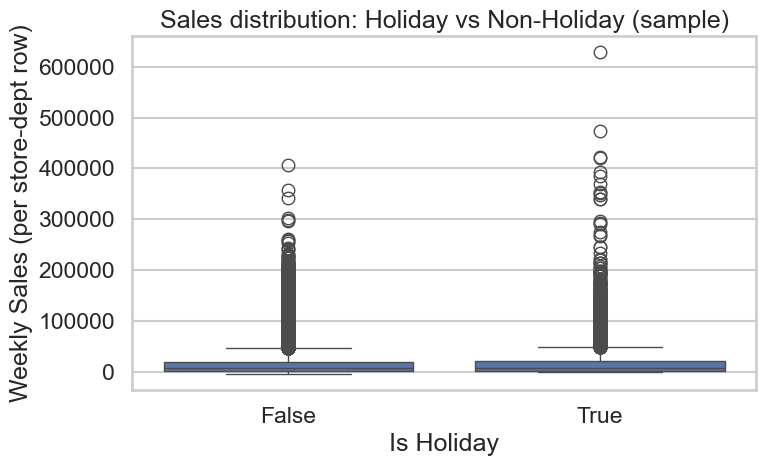

In [22]:
# Task 3: Boxplot holiday vs non-holiday
# For readability sample if dataset is huge; remove .sample(...) if you prefer full plot
sample = master.sample(frac=0.5, random_state=42)  # optional sampling to speed up plotting

plt.figure(figsize=(8,5))
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=sample)
plt.title('Sales distribution: Holiday vs Non-Holiday (sample)')
plt.xlabel('Is Holiday')
plt.ylabel('Weekly Sales (per store-dept row)')
plt.tight_layout()
plt.savefig('figures/holiday_vs_nonholiday_boxplot.png', dpi=300)
plt.show()


4.4 Average Sales by Store Type

* **Visualization:** Bar chart comparing average weekly sales across store types (A, B, C).

* **Insight:** Type A stores (largest) consistently outperform others, likely due to higher customer traffic and product variety.

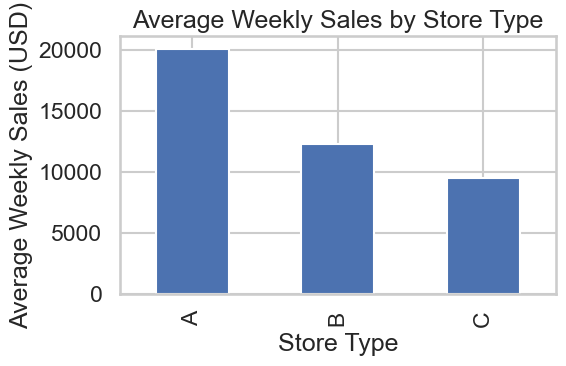

In [24]:
# Task 4: Average sales by Store Type
store_type = master.groupby('Type')['Weekly_Sales'].mean().sort_values(ascending=False)
plt.figure(figsize=(6,4))
store_type.plot(kind='bar')
plt.title('Average Weekly Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Weekly Sales (USD)')
plt.tight_layout()
plt.savefig('figures/storetype_avg_sales.png', dpi=300)
plt.show()


4.5 Top Performing Departments

* **Visualization:** Bar chart of top departments by average weekly sales.

* **Insight:** A few departments dominate total revenue, suggesting that promotions and inventory focus should prioritize these high-performing areas.

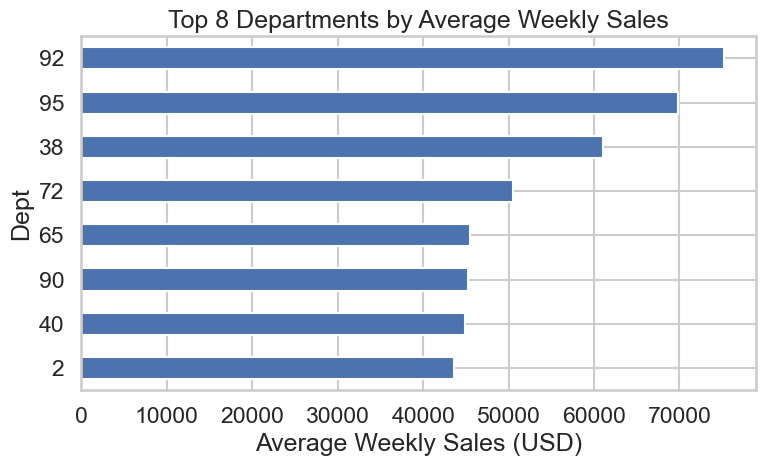

In [23]:
# Task 5: Top departments by average weekly sales
dept_avg = master.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False).head(8)
plt.figure(figsize=(8,5))
dept_avg.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 8 Departments by Average Weekly Sales')
plt.xlabel('Average Weekly Sales (USD)')
plt.tight_layout()
plt.savefig('figures/top_departments_avg_sales.png', dpi=300)
plt.show()


## Step 5 – Share

**Summary of insights**
The analysis revealed clear seasonality and structural performance patterns across Walmart stores. Weekly sales peak around major holidays and gradually decline afterward, highlighting predictable cycles. Type A stores drive the majority of revenue, and a few departments consistently outperform others—making them prime candidates for targeted promotions and optimized stock levels.

**Communication approach**
Insights could be shared through a dashboard (built in Tableau, Power BI, or Python dashboards) and a concise executive report summarizing:

* Weekly and moving-average sales trends

* Holiday vs. non-holiday performance

* Store-type and department comparisons

* Key recommendations for marketing and inventory teams

#### For stakeholders:

* **Store managers** → view store-level dashboards for inventory alignment.

* **Marketing teams** → focus on timing and depth of discounts.

* **Supply-chain planners** → adjust stock allocations to match predicted demand surges.

* **Academic reviewers** → evaluate methodology and reproducibility through the shared notebook.

## Step 6 – Act

**Business recommendations**

1. Holiday readiness: Increase inventory and promotional intensity 2–3 weeks before major holidays to capture seasonal spikes.

2. Department prioritization: Focus on top-performing departments for markdown campaigns; monitor underperforming ones for potential rationalization or assortment refresh.

3. Store-type strategy: Allocate resources proportionally—Type A stores can handle bulk promotions, while smaller types may benefit from niche targeting.

4. Weather & economic factors: Track variables such as temperature, fuel price, and CPI regularly; integrate them into future demand-forecasting models.

5. Automation & dashboards: Deploy a live dashboard to monitor weekly sales KPIs, update automatically from source files, and trigger alerts for anomalies.

#### Next steps for improvement

* Introduce predictive modeling (e.g., regression or machine learning) to forecast future weekly sales.

* Incorporate external datasets—such as regional events or consumer sentiment—to enhance accuracy.

* Conduct A/B testing on promotions to quantify impact.

* Transition from retrospective analysis to real-time analytics for proactive decision-making.